In [1]:
%load_ext autoreload
%autoreload 2
!which python

/home/users/ujjwal.upadhyay/miniconda3/envs/train/bin/python


In [68]:
%matplotlib inline

In [69]:
import yaml
import munch
import torch
import qtrain
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict
from qtrain.models.train_models import qMultiTasker
from qtrain.dataset.infarct import InfarctDataset3D_60k, InfarctDataModule

In [3]:
CHECKPOINT = "/home/users/ujjwal.upadhyay/projects/qtrain/logs/lightning_logs/version_0/checkpoints/valid_seg_miou_epoch=14-valid_metric=0.00-train_metric=0.00-valid_loss=7.67-train_loss=5.05-valid_seg_miou=0.00.ckpt"
YAML_PARAM = "/home/users/ujjwal.upadhyay/projects/qtrain/logs/lightning_logs/version_0/hparams.yaml"

In [16]:
with open(YAML_PARAM) as f:
    args = munch.munchify(yaml.load(f, Loader=yaml.Loader))["args"]
    
# args.model = "multitask_qer"
args

Munch({'accumulate_grad_batches': 8, 'augmentation': True, 'background_index': 0, 'batch_size': 2, 'cls_loss_wts': Munch({'ce': 5}), 'crop': True, 'datapath': '/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_26_07_23.json', 'dataset_class_60k': True, 'encoder_name': 'se_resnet50', 'experiment': 'e2e8_multitasker_seresnet50_224_run1', 'fast_batch_size': 4, 'fast_dev_run': False, 'gpu': [0, 1, 2, 3], 'gradient_clip_algorithm': 'norm', 'gradient_clip_val': 0.5, 'ignore_index': -100, 'img_size': 224, 'max_epoch': 100, 'mode': 'binary', 'model_params': Munch({'attention_type': None, 'cls_ac_dropout': 0.3, 'cls_ac_nclasses': 2, 'cls_ac_pooling': 'avg', 'cls_dropout': 0.3, 'cls_nclasses': 2, 'cls_normal_dropout': 0.3, 'cls_normal_nclasses': 2, 'cls_normal_pooling': 'avg', 'cls_pooling': 'avg', 'decoder_channels': (128, 64, 32, 16), 'depth': 4, 'encoder_name': 'se_resnet50', 'in_channels': 3, 'kernel_size': 5, 'n_segmaps': 2, 'n_slices': 64, 'output_stride': 16, 'seg_activa

In [42]:
model = qMultiTasker(args).model

In [43]:
state_dict = torch.load(CHECKPOINT, map_location="cpu")['state_dict']
new_state_dict = OrderedDict()
for key in state_dict:
    new_state_dict[key[len("model."):]] = state_dict[key]

In [46]:
model.load_state_dict(new_state_dict, strict=False)
model.eval()
model = model.cuda()

MultiTaskSeqAttn(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReL

In [47]:
dm = InfarctDataModule(args)
dataset = dm.setup_dataset(status="valid")

valid data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22606/22606 [00:01<00:00, 15119.51it/s]

22606 scans present in valid data belonging to 1 classes



In [72]:
ct, gt_segmentation_map, trg_cls, infarct_cls, series = dataset[10]
ct.shape, gt_segmentation_map.shape, trg_cls.shape, infarct_cls.shape, series

/home/users/ujjwal.upadhyay/miniconda3/envs/train/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([64, 3, 224, 224]),
 torch.Size([64, 224, 224]),
 torch.Size([1]),
 torch.Size([2]),
 '1.2.840.113619.2.55.3.2831165733.963.1374287489.813')

In [73]:
def get_out(ct):
    out = model(ct.unsqueeze(0).cuda())
    return out
out = get_out(ct)

In [77]:
out["masks"].shape

torch.Size([1, 64, 2, 224, 224])

In [79]:
from qtrain.losses.dice_loss import SoftDiceLoss

In [82]:
gt_segmentation_map.shape

torch.Size([64, 224, 224])

In [83]:
SoftDiceLoss()(out["masks"], gt_segmentation_map.squeeze(0).cuda())

RuntimeError: Index tensor must have the same number of dimensions as self tensor

In [78]:
F.binary_cross_entropy_with_logits(out["masks"], gt_segmentation_map.unsqueeze(0))

ValueError: Target size (torch.Size([1, 64, 224, 224])) must be the same as input size (torch.Size([1, 64, 2, 224, 224]))

In [85]:
F.softmax(out["masks"]).shape

/tmp/ipykernel_131944/3735210192.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(out["masks"]).shape


torch.Size([1, 64, 2, 224, 224])

/tmp/ipykernel_131944/3283971323.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.imshow(F.softmax(out["masks"]).argmax(2)[0].detach().cpu().numpy()[24])


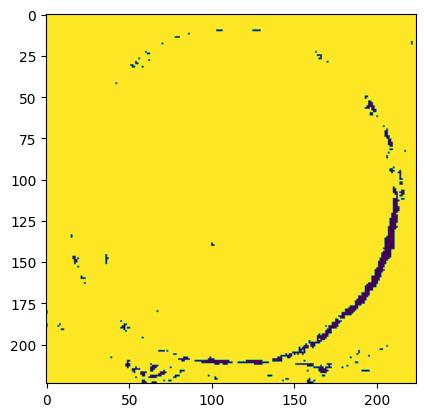

In [75]:
plt.imshow(F.softmax(out["masks"]).argmax(2)[0].detach().cpu().numpy()[24])